Welcome to the new competition. This notebook aims to provide data insights. Please up vote if you find this useful. Happy Kaggling!!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

sample_submission.csv
test.csv
train.csv



In [2]:
# Read the train and test data file
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
print("Total number of samples in train file : ", train.shape[0])
print("Total number of samples in test file : ", test.shape[0])

Total number of samples in train file :  1458644
Total number of samples in test file :  625134


In [3]:
# Let's look at the train data first
print("A view of the train dataframe")
print(train.head())
print("\nColumns in train dataset : ", train.columns)
print("\n")
print("Overall description of the train dataset : ")
print(train.info())

A view of the train dataframe
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N    

In [4]:
# Okay  we have an overview of the train dataset. Before exploring further, let's see if the id column has some overlap with the test ids or not
train_id = set(train['id'].values)
test_id = set(test['id'].values)
print("Number of unique id in train dataset : ", len(train_id))
print("Number of unique id in test dataset : ", len(test_id))
common_ids = train_id.intersection(test_id)
print("Number of common id in the train and test datasets : ", len(common_ids))

Number of unique id in train dataset :  1458644
Number of unique id in test dataset :  625134
Number of common id in the train and test datasets :  0


No overlap in train and test ids. Hence we can drop the id column for now until unless we figure out that there actually was some overlap(by some magic of course!)

In [5]:
# Let's have a look at the traget variable(trip duration) first
target = train['trip_duration']
print("Longest trip duration {} or {} minutes: " .format(np.max(target.values), np.max(target.values)//60))
print("Smallest trip duration {} or {} minutes: ".format(np.min(target.values),np.min(target.values)//60))
print("Average trip duration : {} or {} minutes".format(np.mean(target.values), np.mean(target.values)//60))

Longest trip duration 3526282 or 58771 minutes: 
Smallest trip duration 1 or 0 minutes: 
Average trip duration : 959.4922729603659 or 15.0 minutes


LOL!! Did the rider just opened the door and got out at once? And 58771 minutes?

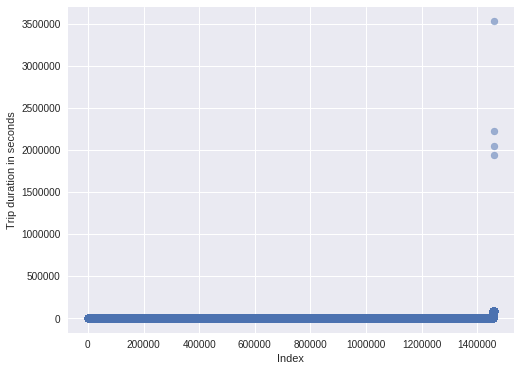

In [6]:
#Visualization is always better 
f = plt.figure(figsize=(8,6))
plt.scatter(range(len(target)), np.sort(target.values), alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Trip duration in seconds')
plt.show()

So there are four outliers in the datset. Should we drop them? We will see about that

Number of unique vendors :  2
How popular is the vendor? 


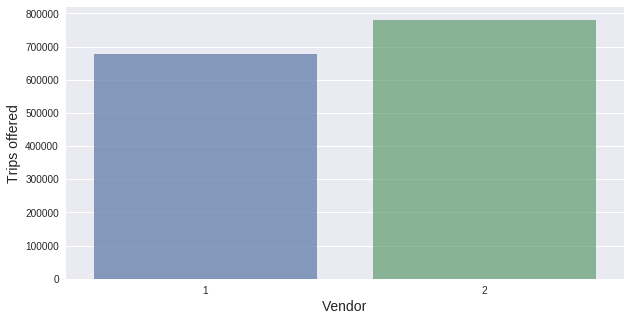

In [7]:
# Moving on to the vendor_id column
unique_vendors = set(train['vendor_id'].values)
print("Number of unique vendors : ", len(unique_vendors))
print("How popular is the vendor? ")
vendor_popularity = train['vendor_id'].value_counts()

f = plt.figure(figsize=(10,5))
sns.barplot(vendor_popularity.index, vendor_popularity.values, alpha=0.7)
plt.xlabel('Vendor', fontsize=14)
plt.ylabel('Trips offered', fontsize=14)
plt.show()

Maximum number of passengers on a trip :  9
Minimum number of passengers on a trip :  0
Average number of passengers on a trip :  1.66452952194


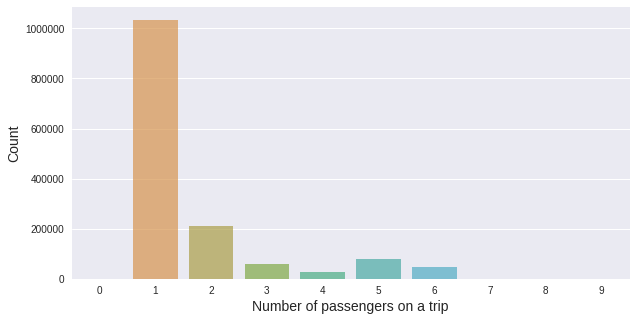

In [8]:
# Moving to passengers count column
pass_count = train['passenger_count']
print("Maximum number of passengers on a trip : ", np.max(pass_count.values))
print("Minimum number of passengers on a trip : ", np.min(pass_count.values))
print("Average number of passengers on a trip : ", np.mean(pass_count.values))

f = plt.figure(figsize=(10,5))
pass_count = train['passenger_count'].value_counts()
sns.barplot(pass_count.index, pass_count.values, alpha=0.7)
plt.xlabel('Number of passengers on a trip', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

9 passengers on a trip. This may be the case where someone hired a taxi for many days. Does this belong to the same data points where our outliers for the trip duration exist?

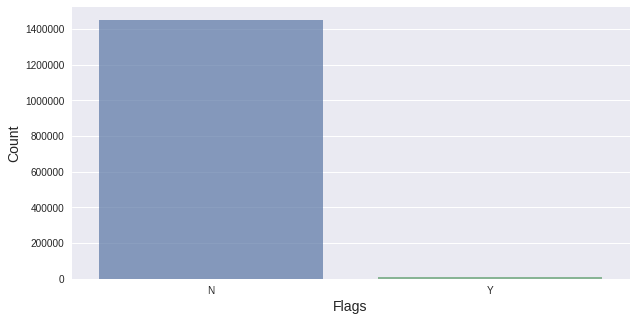

In [9]:
# Let's move to the store_and_fwd_flag column
flags = train['store_and_fwd_flag'].value_counts()

f = plt.figure(figsize=(10,5))
sns.barplot(flags.index, flags.values, alpha=0.7)
plt.xlabel('Flags', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

Let's take a closer look to the pickup and dropoff columns

In [10]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_hour'] = train['pickup_datetime'].dt.hour

train['drop_day'] = train['dropoff_datetime'].dt.day
train['drop_month'] = train['dropoff_datetime'].dt.month
train['drop_weekday'] = train['dropoff_datetime'].dt.weekday
train['drop_hour'] = train['dropoff_datetime'].dt.hour

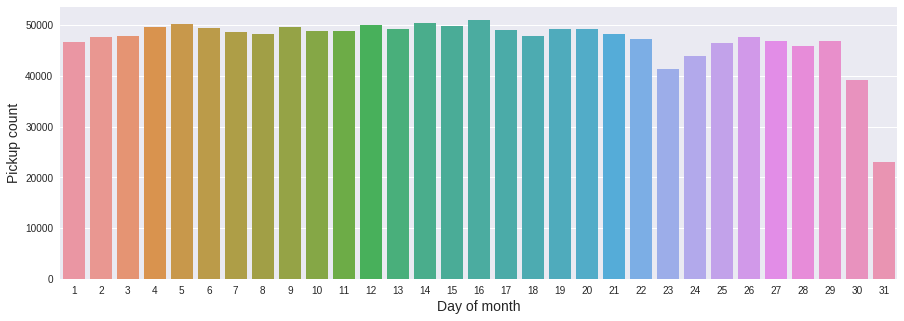

In [11]:
# Do the number of pickups looks same for the whole month? Let's find out
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_day', data=train)
plt.xlabel('Day of month', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

Looks good. No surprising thing here. Let's see how many pickups were there for each month

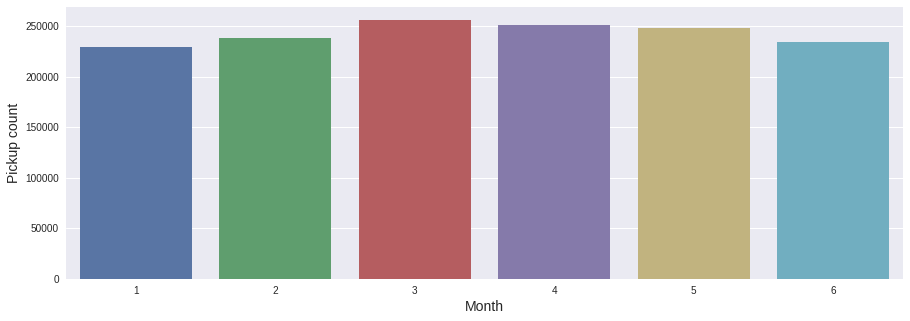

In [12]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_month', data=train)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

Expected because there is no major festive season around these months. Let's move on to the number of pickups on different days of the week

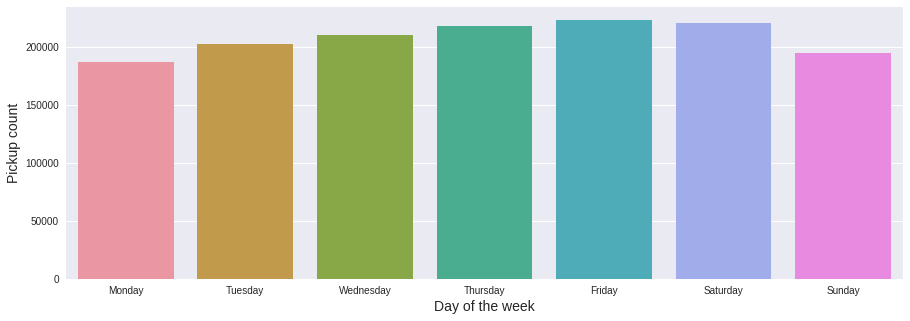

In [13]:
f = plt.figure(figsize=(15,5))
days = [i for i in range(7)]
sns.countplot(x='pickup_weekday', data=train)
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.xticks(days, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.show()

What about hour of the day? Let's check that too

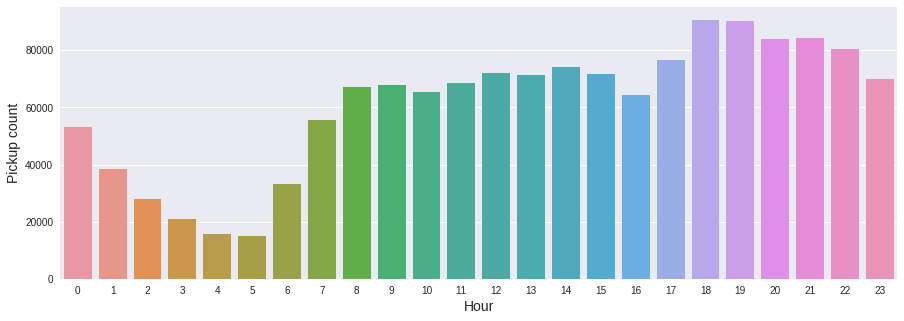

In [14]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_hour', data=train)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

Everything looks good here too. As expected, the number of pickups gradually decreases after mid-night. The highest number of pickups are around 6pm and 7pm in the evening which makes sense as many people are on their way to home from office.

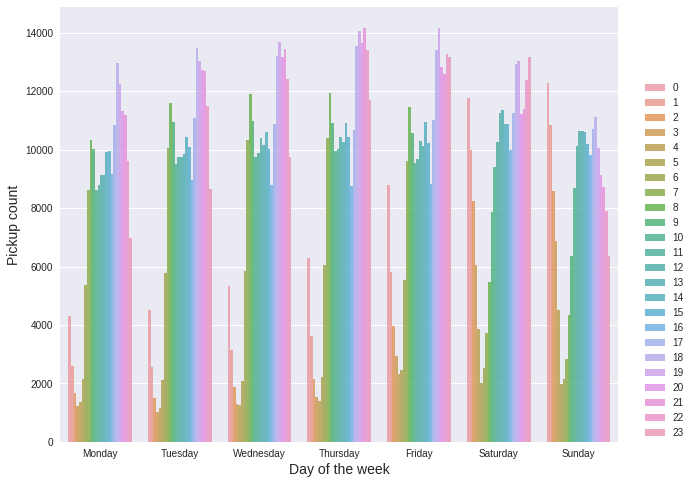

In [15]:
f = plt.figure(figsize=(10,8))
days = [i for i in range(7)]
sns.countplot(x='pickup_weekday', data=train, hue='pickup_hour', alpha=0.8)
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.xticks(days, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.legend(loc=(1.04,0))
plt.show()

Ahh nice plot. Did you notice the peaks at mid-night on Saturday and Sunday? This should be fine because most of the people are doing parties on weekends.

I think the same pattern will be for dropoff_time column. So I am not diving into it right now.